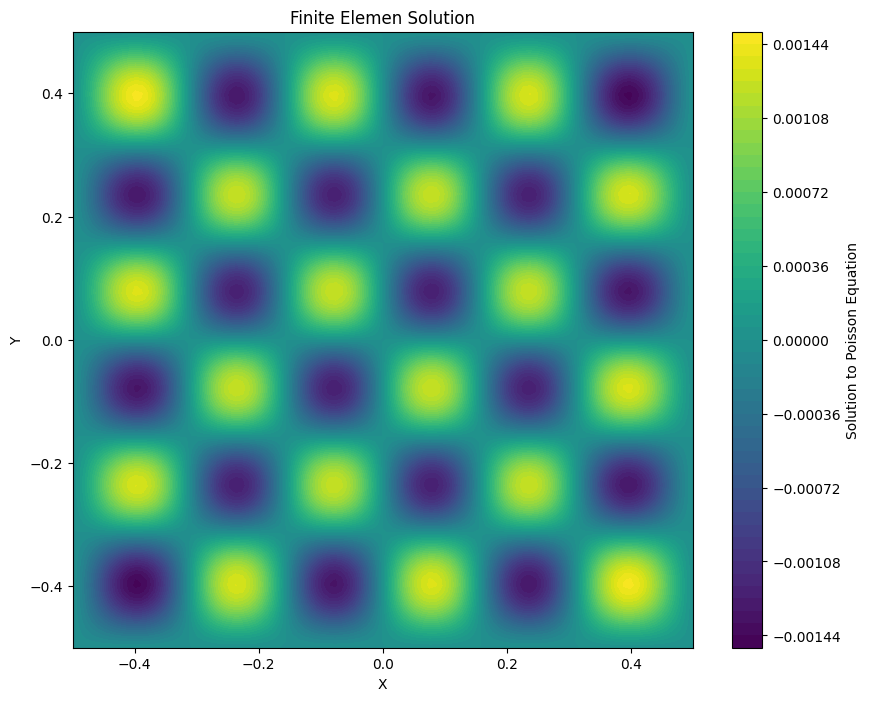

Elapsed time during the whole program in minutes: 0.03224346925000011


In [1]:
# @title Finite Elemen Method
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter

t1_start = perf_counter()

def source_term(X,Y) :
  #r = np.sqrt(X**2 + Y**2)
  #f = -np.exp(-100 * r**2)
  f = np.sin(20*X) * np.sin(20*Y)
  return f


# Solve Poisson equation using finite difference method
def solve_poisson(u, f, max_iter=100000) :
  u_prev = np.zeros_like(u)
  error = []
  for _ in range(max_iter):  # Iterative solver
      u[1:-1, 1:-1] = (dy**2 * (u[:-2, 1:-1] + u[2:, 1:-1]) +
                      dx**2 * (u[1:-1, :-2] + u[1:-1, 2:]) -
                      dx**2 * dy**2 * f[1:-1, 1:-1]) / (2 * (dx**2 + dy**2))
      u_cek = u_prev - u
      u_cek = np.sum(u_cek**2)
      error.append(u_cek)
      if u_cek < 1e-30:
          break
      u_prev = u.copy()
  return u, error

# Define parameters
L = 1.0  # Length of the domain in the x direction
H = 1.0  # Height of the domain in the y direction
Nx = 100  # Number of grid points in the x direction
Ny = 100  # Number of grid points in the y direction
dx = L / (Nx - 1)  # Grid spacing in the x direction
dy = H / (Ny - 1)  # Grid spacing in the y direction
x = np.linspace(0, L, Nx) - 0.5  # Grid points in the x direction
y = np.linspace(0, H, Ny) - 0.5  # Grid points in the y direction
X, Y = np.meshgrid(x, y)  # Meshgrid of the domain

# Define Dirichlet boundary conditions
u_left = np.zeros(Ny)  # Dirichlet boundary condition at x = 0
u_right = np.zeros(Ny)  # Dirichlet boundary condition at x = L
u_bottom = np.zeros(Nx)  # Dirichlet boundary condition at y = 0
u_top = np.zeros(Nx)  # Dirichlet boundary condition at y = H

# Initialize solution array with Dirichlet boundary conditions
u = np.zeros((Ny, Nx))
u[:, 0] = u_left
u[:, -1] = u_right
u[0, :] = u_bottom
u[-1, :] = u_top

f = source_term(X,Y)
result, error = solve_poisson(u,f, 5000)

plt.figure(figsize=(10, 8))
plt.contourf(X, Y, result, 50, cmap='viridis')
plt.colorbar(label='Solution to Poisson Equation')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Finite Elemen Solution')
#plt.grid(True)
plt.show()

t1_stop = perf_counter()
print("Elapsed time during the whole program in minutes:", (t1_stop-t1_start)/60)

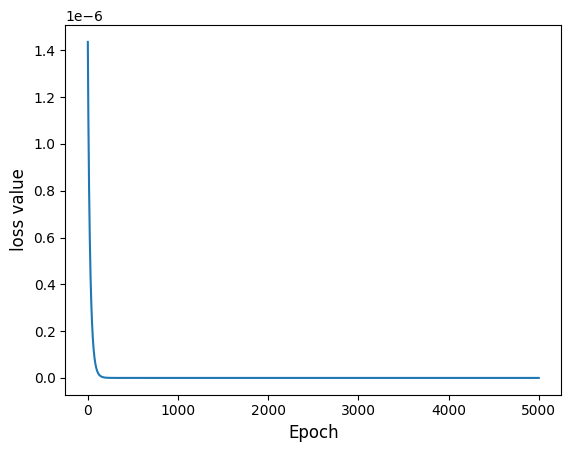

In [ ]:
plt.plot(error)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("loss value", fontsize=12)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# @title Training Model
import torch
import numpy as np

# t1_start = perf_counter()

class FCN(torch.nn.Module) :
  def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN) :
    super().__init__()
    self.fcs = torch.nn.Sequential(
        torch.nn.Linear(N_INPUT, N_HIDDEN),
        torch.nn.Tanh(),
        torch.nn.Linear(N_HIDDEN, N_HIDDEN),
        torch.nn.Tanh(),
        torch.nn.Linear(N_HIDDEN, N_HIDDEN),
        torch.nn.Tanh(),
        torch.nn.Linear(N_HIDDEN, N_HIDDEN),
        torch.nn.Tanh(),
        torch.nn.Linear(N_HIDDEN, N_HIDDEN),
        torch.nn.Tanh(),
        torch.nn.Linear(N_HIDDEN, N_HIDDEN),
        torch.nn.Tanh(),
        torch.nn.Linear(N_HIDDEN, N_OUTPUT),
    )

  def forward(self, x):
    x = self.fcs(x)
    return x

t1_start = perf_counter()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCN(2,1,20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def source_term(X,Y) :
  # r = torch.sqrt(X**2 + Y**2)
  # f = -torch.exp(-100 * r**2)
  f = torch.sin(20*X) * torch.sin(20*Y)
  return f

# Create collocation
data_pred = torch.rand(500,2) - 0.5
data_physics = torch.tensor(data_pred, dtype=torch.float32).requires_grad_(True).to(device)

# Create boundary condition
x = np.linspace(-0.5, 0.5, 50)
y = np.linspace(-0.5, 0.5, 50)
X, Y = np.meshgrid(x, y)
bc1 = np.hstack([X[:,0].reshape(-1,1), Y[:,0].reshape(-1,1)])
bc2 = np.hstack([X[:,-1].reshape(-1,1), Y[:,0].reshape(-1,1)])
bc3 = np.hstack([X[0,:].reshape(-1,1), Y[0,:].reshape(-1,1)])
bc4 = np.hstack([X[-1,:].reshape(-1,1), Y[-1,:].reshape(-1,1)])
bc = np.vstack([bc1,bc2, bc3, bc4])
bc = torch.tensor(bc, dtype=torch.float32).to(device)

epochs = 20000
loss_container = []
for i in range(epochs) :
  optimizer.zero_grad()

  physics_pred = model(data_physics)
  gradien = torch.autograd.grad(physics_pred, data_physics, torch.ones_like(physics_pred), retain_graph=True, create_graph=True)[0]

  dx = gradien[:,0]
  dy = gradien[:,1]
  dx2 = torch.autograd.grad(dx, data_physics, torch.ones_like(dx), create_graph=True)[0][:,0]
  dy2 = torch.autograd.grad(dy, data_physics, torch.ones_like(dy), create_graph=True)[0][:,1]
  sumber = source_term(data_physics[:,0], data_physics[:,1])

  physics = dx2 + dy2 - sumber
  loss_physics = torch.mean(physics**2)

  loss_bc = torch.mean(model(bc)**2)

  loss = (1e-3)*loss_physics + (loss_bc)
  loss_container.append(float(loss))
  loss.backward()
  optimizer.step()

  if i%100 == 0 :
    print("Epoch : {}, loss : {}".format(str(i), str(float(loss))))

t1_stop = perf_counter()
print("Elapsed time during the whole program in minutes:", (t1_stop-t1_start)/60)

<ipython-input-29-5cdc42ba7aa0>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_physics = torch.tensor(data_pred, dtype=torch.float32).requires_grad_(True).to(device)


Epoch : 0, loss : 0.07751993834972382
Epoch : 100, loss : 0.0002459917450323701
Epoch : 200, loss : 0.00023785082157701254
Epoch : 300, loss : 0.00023771885025780648
Epoch : 400, loss : 0.0002377074270043522
Epoch : 500, loss : 0.00023769504332449287
Epoch : 600, loss : 0.00023768184473738074
Epoch : 700, loss : 0.000237668224144727
Epoch : 800, loss : 0.0002376543270656839
Epoch : 900, loss : 0.00023764035722706467
Epoch : 1000, loss : 0.00023762650380376726
Epoch : 1100, loss : 0.00023761286865919828
Epoch : 1200, loss : 0.00023759955365676433
Epoch : 1300, loss : 0.00023758660245221108
Epoch : 1400, loss : 0.00023757413146086037
Epoch : 1500, loss : 0.00023756218433845788
Epoch : 1600, loss : 0.00023755079018883407
Epoch : 1700, loss : 0.00023753996356390417
Epoch : 1800, loss : 0.0002375297190155834
Epoch : 1900, loss : 0.00023752010019961745
Epoch : 2000, loss : 0.00023751110711600631
Epoch : 2100, loss : 0.00023750271066091955
Epoch : 2200, loss : 0.00023749489628244191
Epoch : 2

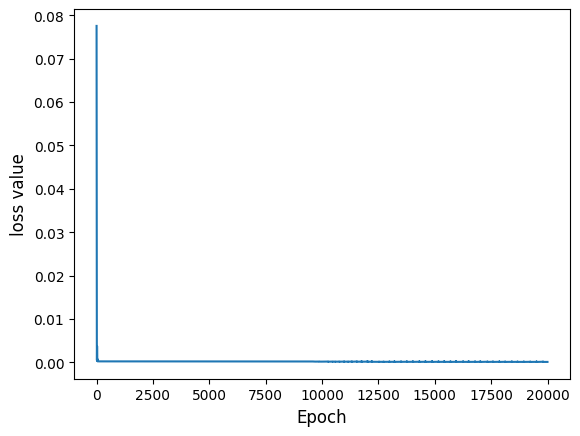

In [ ]:
#@title Save Learning Curve

loss_file = open("loss_value.txt", "w")
i = 1
txt = "epoch  loss_value\n"
loss_file.write(txt)
for ls in loss_container :
  txt = "{}  {:.7f}\n".format(i,ls)
  loss_file.write(txt)
  i += 1

loss_file.close()

plt.plot(loss_container)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("loss value", fontsize=12)
# plt.ylim(0,0.00005)
plt.show()

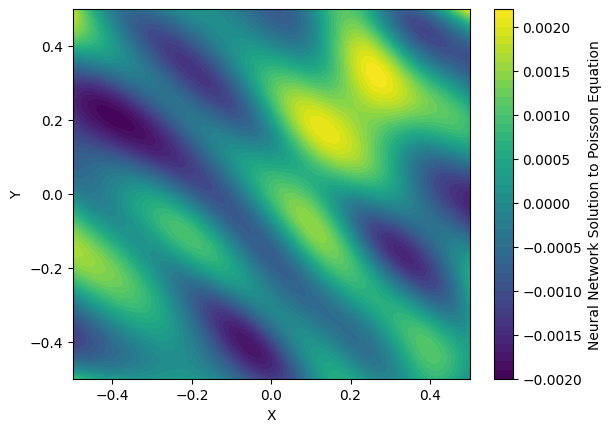

In [ ]:
#@title Inference Solving Poisson Model
Ny = 100
Nx = 100

dx = L / (Nx - 1)  # Grid spacing in the x direction
dy = H / (Ny - 1)  # Grid spacing in the y direction

x = torch.linspace(-0.5, 0.5, steps=Nx)
y = torch.linspace(-0.5, 0.5, steps=Ny)
X, Y = torch.meshgrid(x, y, indexing='xy')

data_pred = torch.hstack([X.reshape(-1,1), Y.reshape(-1,1)]).to(device)
pred = model.to(device)(data_pred).detach().cpu().numpy().reshape(100,100)

plt.contourf(X, Y, pred, 50, cmap='viridis')
plt.colorbar(label='Neural Network Solution to Poisson Equation')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

<ipython-input-32-4ada885f86fd>:47: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mappable, label='Solution to Poisson Equation')


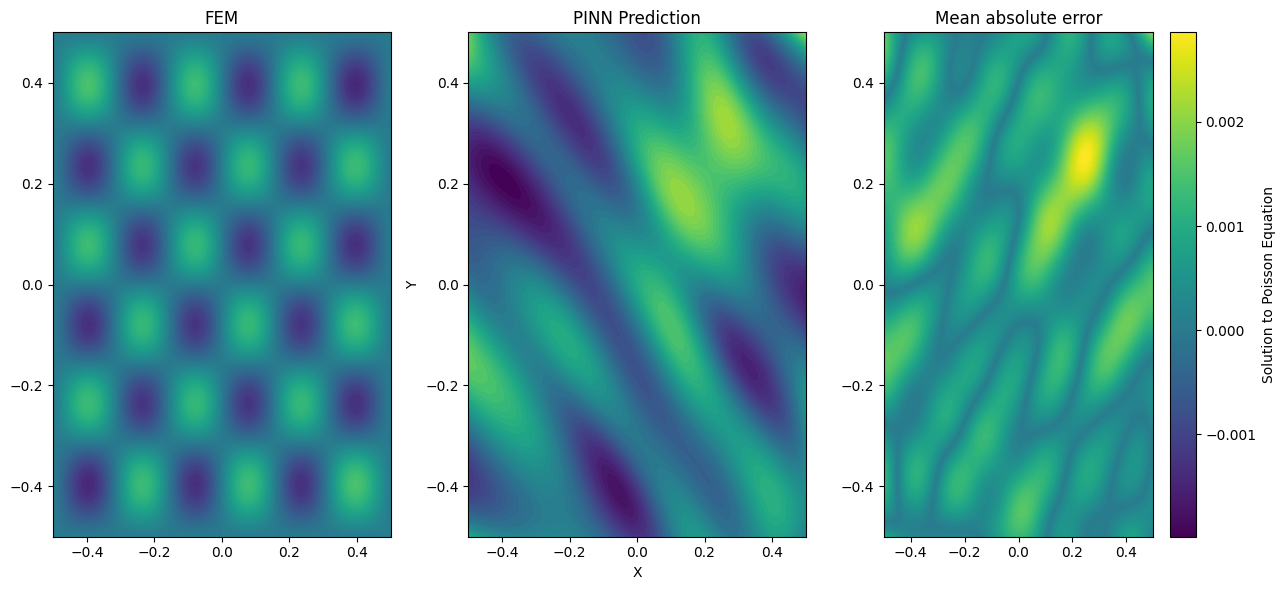

Mean absolute error  0.0006964961534329787


In [ ]:
#@title error comparation

# Define Dirichlet boundary conditions
u_left = np.zeros(Ny)
u_right = np.zeros(Ny)
u_bottom = np.zeros(Nx)
u_top = np.zeros(Nx)

# Initialize solution array with Dirichlet boundary conditions
u = np.zeros((Ny, Nx))
u[:, 0] = u_left
u[:, -1] = u_right
u[0, :] = u_bottom
u[-1, :] = u_top

f = source_term(X,Y)
result, error = solve_poisson(u,f.numpy(), 5000)

error = abs(pred - result)
vmin = min(pred.min(), result.min(), error.min())
vmax = max(pred.max(), result.max(), error.max())

# Combine plots using plt.subplot
plt.figure(figsize=(13, 6))

# Neural Network Prediction plot
plt.subplot(1, 3, 2)
plt.contourf(X, Y, pred, 50, cmap='viridis', vmin=vmin, vmax=vmax)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('PINN Prediction', fontsize=12)

# Finite Element Method plot
plt.subplot(1, 3, 1)
plt.contourf(X, Y, result, 50, cmap='viridis', vmin=vmin, vmax=vmax)
plt.title('FEM', fontsize=12)

# Mean absolute error plot
plt.subplot(1, 3, 3)
plt.contourf(X, Y, error, 50, cmap='viridis', vmin=vmin, vmax=vmax)
plt.title('Mean absolute error', fontsize=12)

# Create a single colorbar
mappable = plt.cm.ScalarMappable(cmap='viridis')
mappable.set_array([])
mappable.set_clim(vmin, vmax)
cbar = plt.colorbar(mappable, label='Solution to Poisson Equation')

plt.tight_layout()
plt.savefig("FEM_PINNs_calculation_comparation.jpg")
plt.show()

print("Mean absolute error ", abs(error).mean())

In [ ]:
0.00011252225664008113
9.892000486348803e-05

9.892000486348802

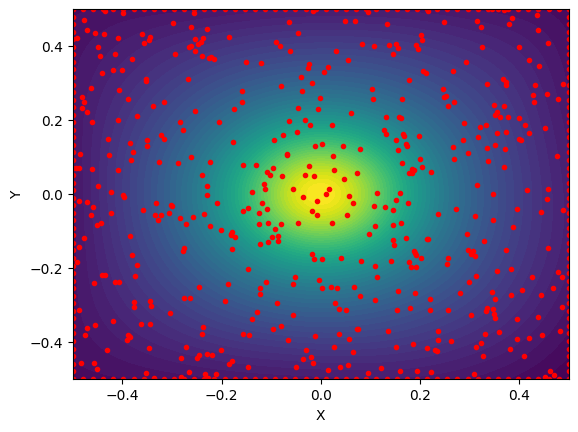

In [ ]:
#@title data distribution

plt.contourf(X, Y, pred, 50, cmap='viridis', vmin=vmin, vmax=vmax)

for data in data_physics.detach().cpu().numpy() :
  plt.plot(data[0], data[1], "r.")

for data in bc.detach().cpu().numpy() :
  plt.plot(data[0], data[1], "r.")

plt.xlabel('X')
plt.ylabel('Y')
#plt.title('Neural Network Prediction', fontsize=12)
plt.savefig("collocation_training_data.jpg")

In [ ]:
len(data_physics)

500

In [ ]:
len(bc)

200

In [ ]:
#@title Training Model PINNS Fourier Features

def source_term(X,Y) :
  f = torch.sin(20*X) * torch.sin(20*Y)
  return f

# Fourier features module
class FourierFeatures(torch.nn.Module):
    def __init__(self, n_input, n_output, sigma=1.0):
        super(FourierFeatures, self).__init__()
        self.B = torch.nn.Parameter(torch.normal(0, sigma, size=(n_input, n_output)), requires_grad=False).to(device)

    def forward(self, x):
        return torch.cat([torch.sin(torch.matmul(x, self.B)), torch.cos(torch.matmul(x, self.B))], dim=-1)

# Model with Fourier features
class FCNWithFourierFeatures(torch.nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_fourier_features=64):
        super().__init__()
        self.fourier_features = FourierFeatures(n_input, n_fourier_features//2)
        self.fcs = torch.nn.Sequential(
            torch.nn.Linear(n_fourier_features, n_hidden),
            torch.nn.Tanh(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.Tanh(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.Tanh(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.Tanh(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.Tanh(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.Tanh(),
            torch.nn.Linear(n_hidden, n_output),
        )

    def forward(self, x):
        x = self.fourier_features(x)
        x = self.fcs(x)
        return x

# Define parameters
L = 1.0  # Length of the domain in the x direction
H = 1.0  # Height of the domain in the y direction
Nx = 100  # Number of grid points in the x direction
Ny = 100  # Number of grid points in the y direction
dx = L / (Nx - 1)  # Grid spacing in the x direction
dy = H / (Ny - 1)  # Grid spacing in the y direction
x = np.linspace(0, L, Nx) - 0.5  # Grid points in the x direction
y = np.linspace(0, H, Ny) - 0.5  # Grid points in the y direction
X, Y = np.meshgrid(x, y)  # Meshgrid of the domain

# Instantiate model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCNWithFourierFeatures(2, 1, 10, n_fourier_features=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Create collocation
data_pred = torch.rand(500,2) - 0.5
data_physics = torch.tensor(data_pred, dtype=torch.float32).requires_grad_(True).to(device)

# Define boundary conditions
bc1 = np.hstack([X[:,0].reshape(-1,1), Y[:,0].reshape(-1,1)])
bc2 = np.hstack([X[:,-1].reshape(-1,1), Y[:,0].reshape(-1,1)])
bc3 = np.hstack([X[0,:].reshape(-1,1), Y[0,:].reshape(-1,1)])
bc4 = np.hstack([X[-1,:].reshape(-1,1), Y[-1,:].reshape(-1,1)])
bc = np.vstack([bc1,bc2, bc3, bc4])
bc = torch.tensor(bc, dtype=torch.float32).to(device)

epochs = 20000
loss_container = []
for i in range(epochs) :
  optimizer.zero_grad()

  physics_pred = model(data_physics)
  gradien = torch.autograd.grad(physics_pred, data_physics, torch.ones_like(physics_pred), retain_graph=True, create_graph=True)[0]

  dx = gradien[:,0]
  dy = gradien[:,1]
  dx2 = torch.autograd.grad(dx, data_physics, torch.ones_like(dx), create_graph=True)[0][:,0]
  dy2 = torch.autograd.grad(dy, data_physics, torch.ones_like(dy), create_graph=True)[0][:,1]
  sumber = source_term(data_physics[:,0], data_physics[:,1])

  physics = dx2 + dy2 - sumber
  loss_physics = torch.mean(physics**2)

  loss_bc = torch.mean(model(bc)**2)

  loss = (1e-3)*loss_physics + loss_bc

  loss_container.append(float(loss))
  loss.backward()
  optimizer.step()

  if i%100 == 0 :
    print("Epoch : {}, loss : {}".format(str(i), str(float(loss))))

<ipython-input-49-0b02c1e0b6e0>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_physics = torch.tensor(data_pred, dtype=torch.float32).requires_grad_(True).to(device)


Epoch : 0, loss : 0.011895913630723953
Epoch : 100, loss : 0.00024856155505403876
Epoch : 200, loss : 0.00024810805916786194
Epoch : 300, loss : 0.00024786844733171165
Epoch : 400, loss : 0.0002476693771313876
Epoch : 500, loss : 0.0002474996726959944
Epoch : 600, loss : 0.00024734955513849854
Epoch : 700, loss : 0.00024721137015149
Epoch : 800, loss : 0.0002470766776241362
Epoch : 900, loss : 0.0002469142491463572
Epoch : 1000, loss : 0.00024641724303364754
Epoch : 1100, loss : 0.00024446696625091136
Epoch : 1200, loss : 0.00024332849716302007
Epoch : 1300, loss : 0.00024144200142472982
Epoch : 1400, loss : 0.00023193993547465652
Epoch : 1500, loss : 0.00019825209164991975
Epoch : 1600, loss : 0.00019280097330920398
Epoch : 1700, loss : 0.00018687434203457087
Epoch : 1800, loss : 0.00016762582527007908
Epoch : 1900, loss : 0.00014224526239559054
Epoch : 2000, loss : 0.00012994464486837387
Epoch : 2100, loss : 0.0001243952865479514
Epoch : 2200, loss : 0.00011935719521716237
Epoch : 23

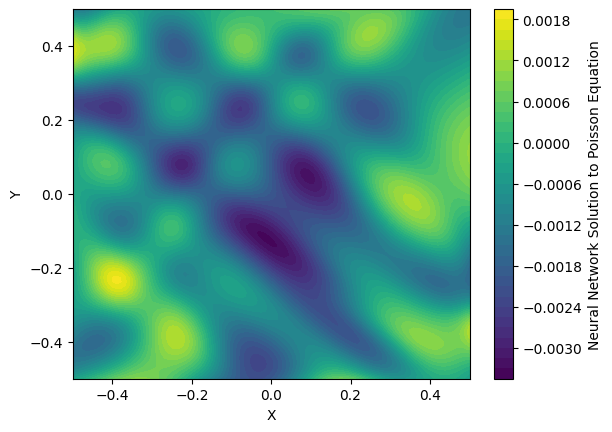

In [ ]:
#@title Inference Solving Poisson Model PINNS Fourier Features
Ny = 100
Nx = 100

dx = L / (Nx - 1)  # Grid spacing in the x direction
dy = H / (Ny - 1)  # Grid spacing in the y direction

x = torch.linspace(-0.5, 0.5, steps=Nx)
y = torch.linspace(-0.5, 0.5, steps=Ny)
X, Y = torch.meshgrid(x, y, indexing='xy')

data_pred = torch.hstack([X.reshape(-1,1), Y.reshape(-1,1)]).to(device)
pred = model.to(device)(data_pred).detach().cpu().numpy().reshape(100,100)

plt.contourf(X, Y, pred, 50, cmap='viridis')
plt.colorbar(label='Neural Network Solution to Poisson Equation')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

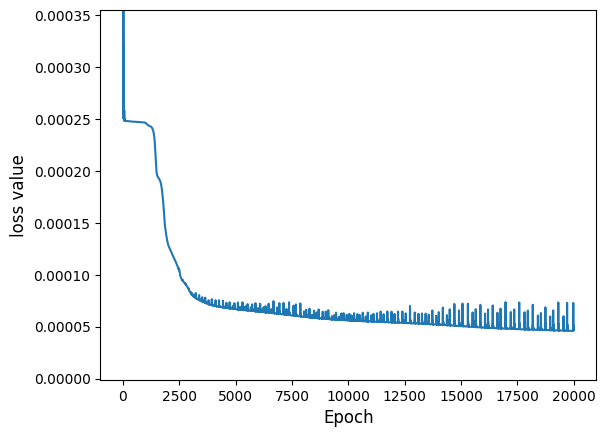

In [ ]:
#@title Save Learning Curve

loss_file = open("loss_value_PINNS_FF.txt", "w")
i = 1
txt = "epoch  loss_value\n"
loss_file.write(txt)
for ls in loss_container :
  txt = "{}  {:.7f}\n".format(i,ls)
  loss_file.write(txt)
  i += 1

loss_file.close()

plt.plot(loss_container)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("loss value", fontsize=12)
plt.ylim(-0.000001,0.000355)
plt.show()

<ipython-input-55-4ada885f86fd>:47: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mappable, label='Solution to Poisson Equation')


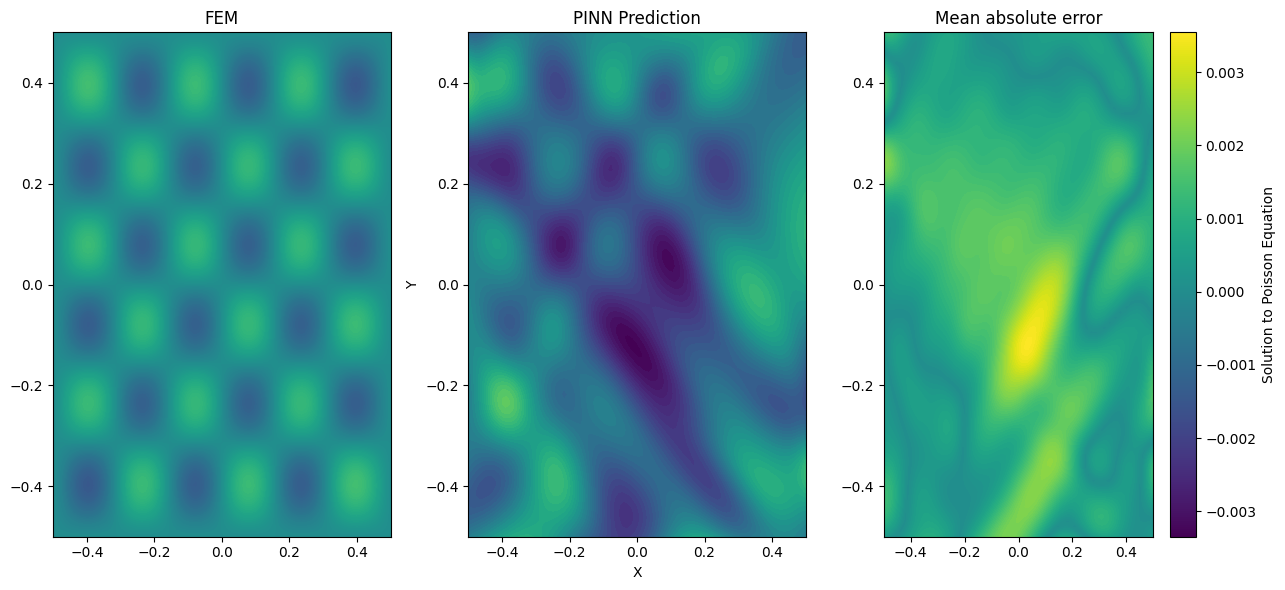

Mean absolute error  0.0009586958469479189


In [ ]:
#@title error comparation

# Define Dirichlet boundary conditions
u_left = np.zeros(Ny)
u_right = np.zeros(Ny)
u_bottom = np.zeros(Nx)
u_top = np.zeros(Nx)

# Initialize solution array with Dirichlet boundary conditions
u = np.zeros((Ny, Nx))
u[:, 0] = u_left
u[:, -1] = u_right
u[0, :] = u_bottom
u[-1, :] = u_top

f = source_term(X,Y)
result, error = solve_poisson(u,f.numpy(), 5000)

error = abs(pred - result)
vmin = min(pred.min(), result.min(), error.min())
vmax = max(pred.max(), result.max(), error.max())

# Combine plots using plt.subplot
plt.figure(figsize=(13, 6))

# Neural Network Prediction plot
plt.subplot(1, 3, 2)
plt.contourf(X, Y, pred, 50, cmap='viridis', vmin=vmin, vmax=vmax)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('PINN Prediction', fontsize=12)

# Finite Element Method plot
plt.subplot(1, 3, 1)
plt.contourf(X, Y, result, 50, cmap='viridis', vmin=vmin, vmax=vmax)
plt.title('FEM', fontsize=12)

# Mean absolute error plot
plt.subplot(1, 3, 3)
plt.contourf(X, Y, error, 50, cmap='viridis', vmin=vmin, vmax=vmax)
plt.title('Mean absolute error', fontsize=12)

# Create a single colorbar
mappable = plt.cm.ScalarMappable(cmap='viridis')
mappable.set_array([])
mappable.set_clim(vmin, vmax)
cbar = plt.colorbar(mappable, label='Solution to Poisson Equation')

plt.tight_layout()
plt.savefig("FEM_PINNs_calculation_comparation.jpg")
plt.show()

print("Mean absolute error ", abs(error).mean())

In [ ]:
regex_cont = "hidden.*?Mean absolute error.*?[0-9]*\.[0-9]*"
reobj = re.compile(regex_cont, re.DOTALL)
learning_curve = open("learning_curve.txt", "r")
learning_curve = learning_curve.read()
all_cont = reobj.findall(learning_curve)

hasil_curve = []

for i in range(len(all_cont)) :
    regex_layer = "hidden\s+layer\s+(\d+)\s+"
    reobj = re.compile(regex_layer, re.DOTALL)
    layer_num = reobj.findall(all_cont[i])
    layer_num = int(layer_num[0])

    regex_ffn = "hidden\s+layer\s+\d+\s+(.*?)\n"
    reobj = re.compile(regex_ffn, re.DOTALL)
    layer_ffn = reobj.findall(all_cont[i])[0]

    regex_loss = "(?<=loss\s:\s)[0-9\.e-]+"
    reobj = re.compile(regex_loss, re.DOTALL)
    loss = reobj.findall(all_cont[i])
    loss = np.array(loss).astype(float)

    regex_mean = "Mean absolute error.*?([0-9]*\.[0-9]*)"
    reobj = re.compile(regex_mean, re.DOTALL)
    mean = reobj.findall(all_cont[i])
    mean = np.array(mean).astype(float)
    hasil_curve.append([layer_num, layer_ffn, loss, mean])

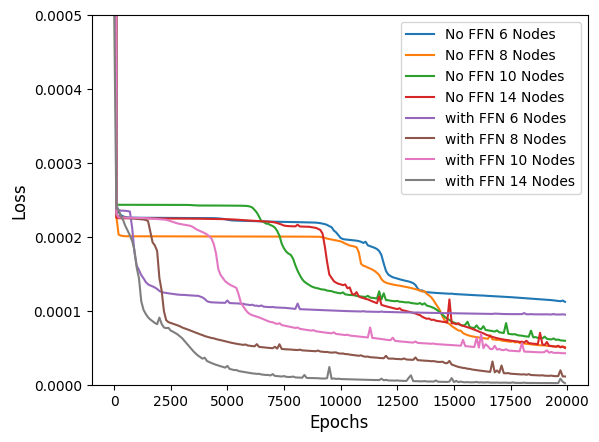

In [ ]:
for elem in hasil_curve:
    number = elem[0]
    category = elem[1]
    loss = elem[2]

    label = category + " " + str(number) + " Nodes"
    plt.plot(np.arange(len(loss))*100, loss, label=label)

plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.ylim(0,0.0005)
plt.savefig("Learning_curve_comparation_ffn.jpg")
plt.show()